## Bear Detector & Classifier

<p>We'll be discriminating between three types of bear: grizzly, black, and teddy bears. We just need a way to find them and download them.</p>

In [53]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [54]:
#hide
from fastbook import *
from fastai.vision.widgets import *

<p>I signed up at Microsoft Azure, created a resource group, followed by the Bing Search API service. A key was generated, which I copied and entered in the cell below.</p>

In [55]:
key = os.environ.get('AZURE_SEARCH_KEY', '92298637b4404b1783fcf346c6d80b97')

In [56]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

<p>What the code block below implies is that we've successfully downloaded the URLs of 150 grizzly bears (i.e., images that Bing Image Search finds for that search term).</p>

In [57]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

<p>Including one of these images below:</p>

In [58]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

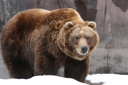

In [59]:
im = Image.open(dest)
im.to_thumb(128,128)

This worked well, so we can use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder.

In [60]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [61]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

The code block below is just to ensure that our folder has image files.

In [62]:
fns = get_image_files(path)
fns

(#402) [Path('bears/grizzly/470dd3d3-e39d-4f7b-a3e7-ccfc61bf0d0d.jpg'),Path('bears/grizzly/a3637343-fe12-444f-93b5-7d63f9f1b38f.jpg'),Path('bears/grizzly/f89afac2-3320-4de6-bca6-9c6d04b5d87d.jpg'),Path('bears/grizzly/a8b869bd-8d19-4980-af54-eff9fd0caeac.jpg'),Path('bears/grizzly/7ebe96bc-f4b8-4db1-9894-ef774df559d2.jpg'),Path('bears/grizzly/566513f3-df58-4920-aa33-9033dd122f71.jpg'),Path('bears/grizzly/a3dc9ea9-82d0-423b-9cac-f9f39fad9f56.jpg'),Path('bears/grizzly/e8cfa78b-21b7-4f09-a84d-9e21b7d8eb67.jpg'),Path('bears/grizzly/ebe6e250-8286-4ab3-8589-20364d9ccc94.jpg'),Path('bears/grizzly/bbccb15e-d565-4964-a9cf-b68162411818.jpg')...]

A few of the downloaded files might be corrupt...

In [63]:
failed = verify_images(fns)
failed

(#0) []

To remove all the failed images, you can use `unlink`.

In [64]:
failed.map(Path.unlink);

In case you need help with documentation...

In [65]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /usr/local/lib/python3.9/dist-packages/fastai/vision/utils.py
Type:      function


DataLoaders is a thin class that stores whatever DataLoader objects you pass to it and makes them available as train and valid.

In [66]:
class DataLoaders(GetAttr):
    def _init_(self, *loaders): self.loaders = loaders
    def _getitem_(self, i): return self.loaders[i]
    train, valid = add_props(lambda i, self: self[i]) 

Below we'll see what we need to create a `DataLoaders` for the dataset we just downloaded.

* First we provide a tuple that specifies the types we want for the independent and dependent variables. In this case, the independent variable is a set of images, and our dependent variables are the categories (type of bear) for each image.
* The `get_image_files` function takes a path, and returns a list of all the images in that path.
* We want to split our training and validation sets randomly. Setting a random seed here so we get the exact same list each time.
* `parent_label` is the function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.
* Rather than feeding the model with images one at a time, we do so in mini-batches. To group them in a tensor (big array) that is going to go through the model, they all need to be of the same size. We use a `Resize` transform here and specify a size of 128 pixels.

In [67]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128))

The command above gives us a `DataBlock` object. This is like a template for creating a `DataLoaders`. The first line below reveals the actual source of the data - in this case, the path where the images can be found. By calling the `show_batch` method, we can view a few of the items that have been stacked up into a single tensor.

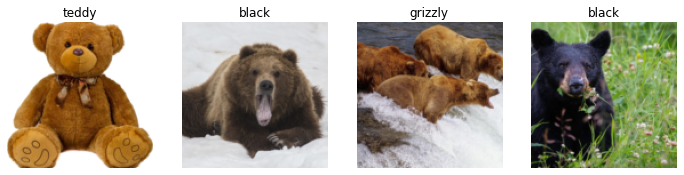

In [68]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

By default, `Resize` crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details.

You can ask fastai to pad the images with zeros (black), or squish/stretch them. These actions are somewhat wasteful/problematic. They create unrealistic shapes that leads to a model that learns that things look different from what they actually are. This results in lower accuracy.

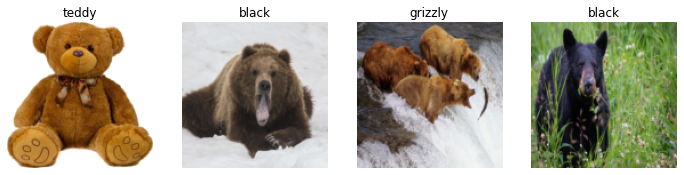

In [69]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

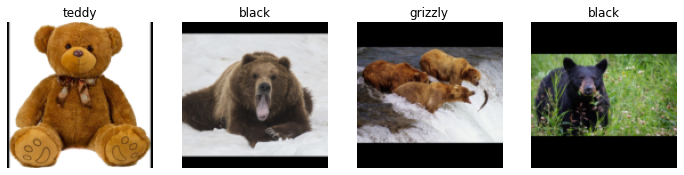

In [70]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Now we replace `Resize` with `RandomResizedCrop`. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time. On the last line, we set `unique` to `True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

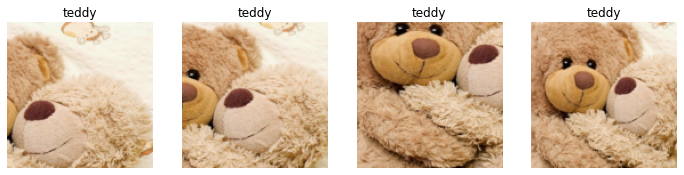

In [71]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter. We're using double the amount of augmentation compared to the default, for the same reason.

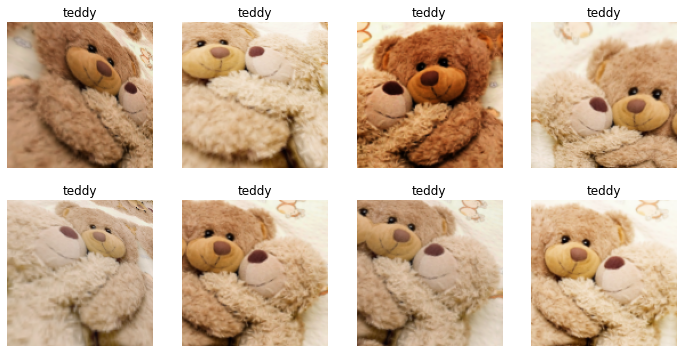

In [72]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Since we don't have a lot of data for our problem, we'll use `RandomResizedCrop`, an image size of 224 pixels, which is fairly standard for image classification, and the default `aug_transforms`.

In [73]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way.

In [74]:
import warnings
warnings.filterwarnings('ignore')
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.189707,0.163684,0.050000,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.256968,0.151136,0.025000,00:15
1,0.179110,0.211433,0.037500,00:16
2,0.142099,0.235011,0.037500,00:15
3,0.113887,0.238575,0.037500,00:17


In the confusion matrix below, the diagonals represent the images that were classified correctly, and the off-diagonal cells represent those that were classified incorrectly.

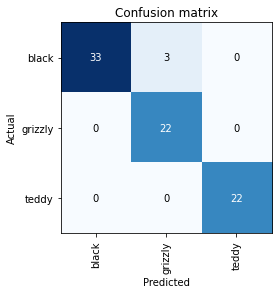

In [75]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The <i>loss</i> is the number that is higher if the model is incorrect (especially if it's confident of its incorrect answer), or if it's correct but not confident of its correct answer. `plot_top_losses` shows us the images with the highest loss in our dataset. The <i>probability</i> here is the confidence level, from zero to one, that the model has assigned to its prediction.

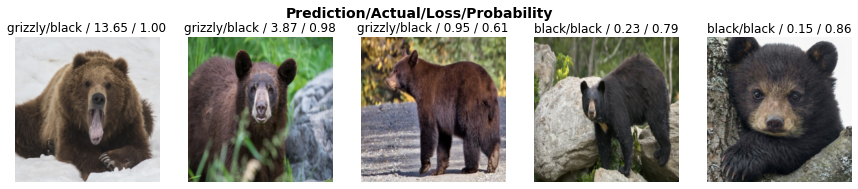

In [76]:
interp.plot_top_losses(5, nrows=1)

fastai has a handy GUI for data cleaning called `ImageClassifierCleaner`. It allows you to choose a category, the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling.

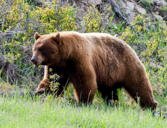

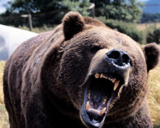

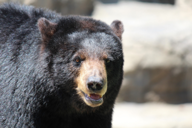

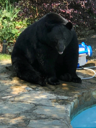

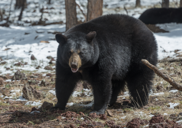

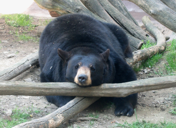

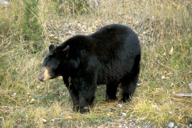

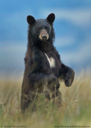

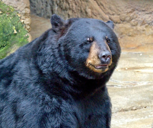

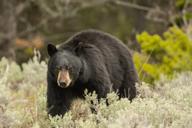

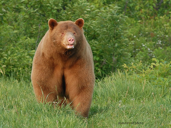

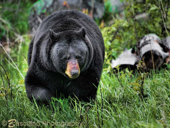

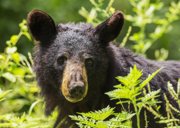

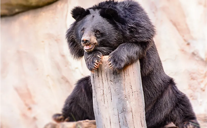

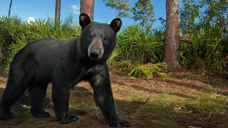

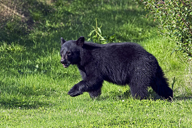

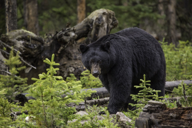

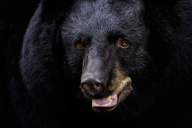

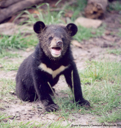

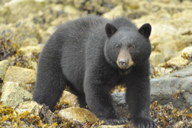

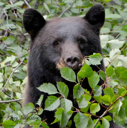

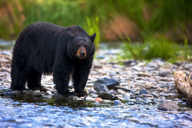

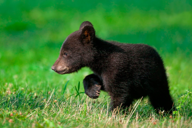

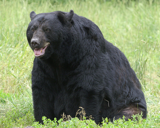

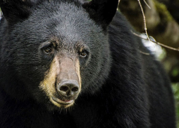

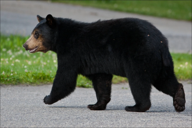

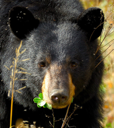

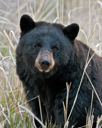

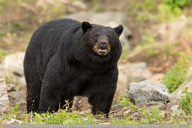

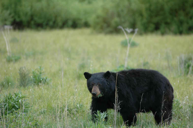

In [77]:
cleaner = ImageClassifierCleaner(learn)
cleaner

To delete (`unlink`) all images selected for deletion, we would run this:

In [78]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

To move images for which we've selected a different category, we would run this:

In [79]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

When you call `export`, fastai will save a file called <i>export.pkl</i>.

In [80]:
learn.export()

Checking that this file exists using the `ls` method.

In [81]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

When we use a model for getting predictions, instead of training, we call it <i>inference</i>. To create our inference learner from the exported file, we use `load_learner`.

In [82]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally getting predictions for just one image at a time. To do this, we pass a filename to `predict`. This returns 3 things: (a) the predicted category in the same format as originally provided, (b) the index of the predicted category, and (c) the probabilities of each category. 

In [83]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([2.9753e-06, 9.9999e-01, 2.4783e-06]))

Those 3 probabilities listed above are in the same order as the labels listed as part of the <i>vocab</i> below of `DataLoaders`.

In [84]:
labels = learn_inf.dls.vocab
labels

['black', 'grizzly', 'teddy']

## Creating a Notebook App from the Model

With ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier.

In [85]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

Now we can grab the image:

In [86]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it.

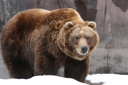

Output()

In [87]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [88]:
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

Now we can get our predictions:

In [89]:
pred,pred_idx,probs = learn_inf.predict(img)

And use a `Label` to display them.

In [90]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

We'll need a button to do the classification. It looks exactly like the Upload button.

In [91]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a <i>click event handler</i>, that is, a function that will be called when it's pressed.

In [92]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

We can now put this all in vertical box (`VBox`) to complete our GUI.

In [93]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])